# Diabetes Classifier

The dataset consists of 10000 samples with 8 features, having nominal and metric scales, and a target with two categories.<br>
The dataset is highly imbalanced with roughly an 10:1 ration between the two labels.<br>
The goal is to build a model to predict if a patient has diabetes or not with an emphasis on avoiding false negatives.<br>
The dataset is available on kaggle 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 

In [2]:
data_path = r"D:\Datasets\Diabetes\diabetes_prediction_dataset.csv"

## Data exploration

In [3]:
data = pd.read_csv(data_path)
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
data.blood_glucose_level.quantile(.95)

200.0

In [5]:
gender_diabets_df = data[['gender', 'diabetes']].value_counts()
gender_diabets_df

gender  diabetes
Female  0           54091
Male    0           37391
Female  1            4461
Male    1            4039
Other   0              18
Name: count, dtype: int64

<Axes: xlabel='gender'>

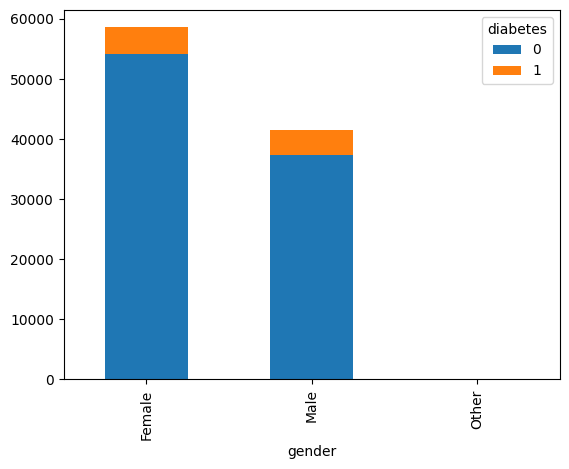

In [6]:
x = gender_diabets_df.unstack()
x.plot(kind='bar', stacked = True)

In [7]:
# droping rows with gender = 'other'
data.drop(index = data[data.gender == 'Other'].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data.gender.value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [8]:
smoke_fem = data.query(' gender == "Female" ').smoking_history.value_counts()
smoke_mal = data.query(' gender == "Male" ').smoking_history.value_counts()

hyp_fem = data.query(' gender == "Female" ').hypertension.value_counts()
hyp_mal = data.query(' gender == "Male" ').hypertension.value_counts()

heart_fem = data.query(' gender == "Female" ').heart_disease.value_counts()
heart_mal = data.query(' gender == "Male" ').heart_disease.value_counts()

criterions = list(data.smoking_history.unique())
no_diabetes =[]
diabetes = []
for crit in criterions:
    another_dict = {}
    neg = len(data.query(" smoking_history == @crit & diabetes == 0 "))
    pos = len(data.query(" smoking_history == @crit & diabetes == 1 "))
    no_diabetes.append(neg/(neg+pos))
    diabetes.append(1-neg/(neg+pos))

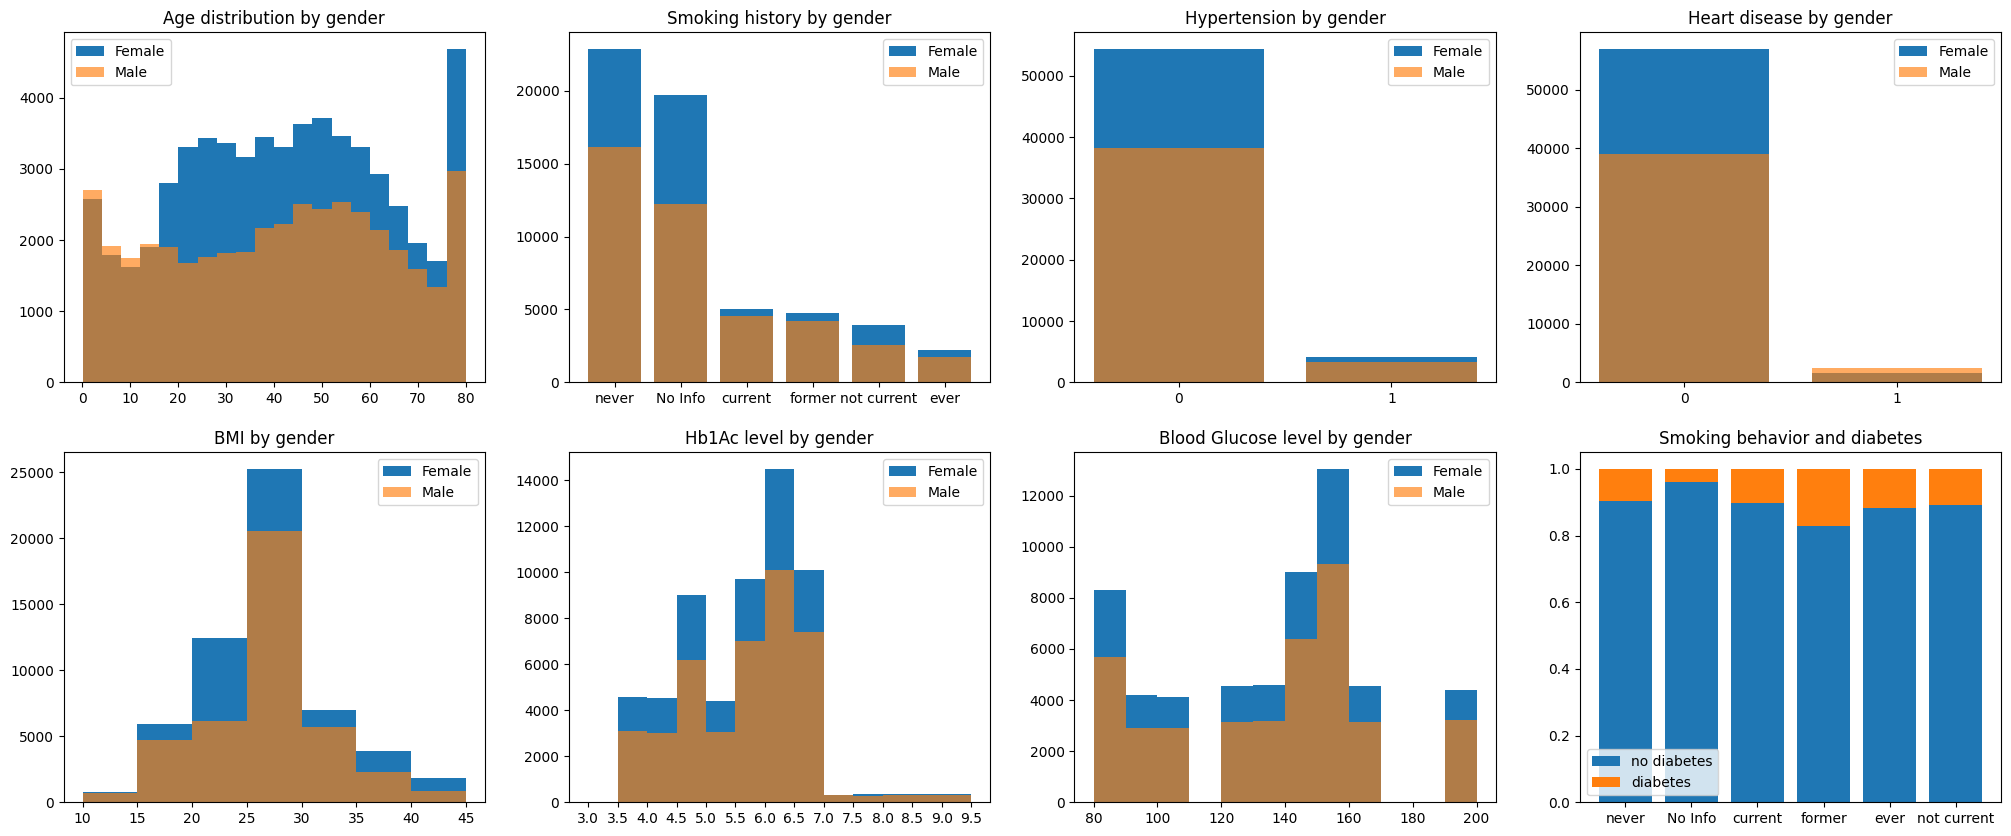

In [9]:
plt.figure(figsize=(25,10))

plt.subplot(241)
plt.hist(data.query(' gender == "Female" ').age, bins=20, label='Female')
plt.hist(data.query(' gender == "Male" ').age, bins=20, alpha=.65, label='Male')
plt.legend()
plt.title("Age distribution by gender")

plt.subplot(242)
plt.bar(smoke_fem.index, smoke_fem, label='Female')
plt.bar(smoke_fem.index, smoke_mal, label = 'Male', alpha=.65)
plt.title("Smoking history by gender")
plt.legend()

plt.subplot(243)
plt.bar(hyp_fem.index, hyp_fem, label='Female')
plt.bar(hyp_fem.index, hyp_mal, label = 'Male', alpha=.65)
plt.title("Hypertension by gender")
plt.xticks([0,1])
plt.legend()

plt.subplot(244)
plt.bar(heart_fem.index, heart_fem, label='Female')
plt.bar(heart_fem.index, heart_mal, alpha=.65, label = 'Male')
plt.title("Heart disease by gender")
plt.xticks([0,1])
plt.legend()

plt.subplot(245)
plt.hist(data.query(' gender == "Female" ').bmi, bins=range(10,50,5), label='Female')
plt.hist(data.query(' gender == "Male" ').bmi, bins=range(10,50,5), alpha=.65, label='Male')
plt.legend()
plt.title('BMI by gender')

plt.subplot(246)
plt.hist(data.query(' gender == "Female" ').HbA1c_level, bins=[x/2 for x in range(6,20)], label='Female')
plt.hist(data.query(' gender == "Male" ').HbA1c_level, bins=[x/2 for x in range(6,20)], alpha=.65, label='Male')
plt.xticks([x/2 for x in range(6,20)])
plt.legend()
plt.title('Hb1Ac level by gender')

plt.subplot(247)
plt.hist(data.query(' gender == "Female" ').blood_glucose_level, bins=range(80,210,10), label='Female')
plt.hist(data.query(' gender == "Male" ').blood_glucose_level,  bins=range(80,210,10), alpha=.65, label='Male')
plt.legend()
plt.title('Blood Glucose level by gender')

plt.subplot(248)
plt.bar(criterions, no_diabetes, label="no diabetes",)
plt.bar(criterions, diabetes, bottom=no_diabetes, label="diabetes")
plt.title("Smoking behavior and diabetes")
plt.legend()

plt.show()

In [10]:
former = data.query(' smoking_history == "former" ')
no_former = data.query(' smoking_history != "former" ')

In [11]:
former.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000,9352.000000
mean,57.061698,0.143178,0.097092,29.620746,5.651861,143.214713,0.170017
std,16.528686,0.350273,0.296098,6.378794,1.145282,45.372222,0.375668
min,7.000000,0.000000,0.000000,10.770000,3.500000,80.000000,0.000000
25%,46.000000,0.000000,0.000000,26.107500,4.800000,100.000000,0.000000
50%,59.000000,0.000000,0.000000,27.630000,5.800000,145.000000,0.000000
75%,70.000000,0.000000,0.000000,32.400000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,83.740000,9.000000,300.000000,1.000000


In [12]:
no_former.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,90630.000000,90630.000000,90630.000000,90630.000000,90630.000000,90630.000000,90630.000000
mean,40.322328,0.067814,0.033477,27.083423,5.514699,137.525676,0.076244
std,22.471010,0.251428,0.179879,6.617602,1.061845,40.160156,0.265390
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,22.000000,0.000000,0.000000,23.320000,4.800000,100.000000,0.000000
50%,41.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,58.000000,0.000000,0.000000,29.180000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


## Data preprocessing

+ In general there seems to be only a weak correlation between smoking history and diabetes
+ The increased amount of diabetes positives among former smokers is likely explained by other characteristcs:
  + higher average age
  + greater fraction of samples with hypertension
  + greater fraction of samples with heart disease

Thus the smoking history is no good predictor for diabetes and thus gets dropped

In [13]:
X = data.drop(['diabetes','smoking_history'], axis=1)
y = data.diabetes

X.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level'],
      dtype='object')

In [14]:
X = pd.get_dummies(X, drop_first=True)
X.head()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male
0,80.0,0,1,25.19,6.6,140,False
1,54.0,0,0,27.32,6.6,80,False
2,28.0,0,0,27.32,5.7,158,True
3,36.0,0,0,23.45,5.0,155,False
4,76.0,1,1,20.14,4.8,155,True


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=11, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79985, 7), (19997, 7), (79985,), (19997,))

In [16]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True) 

(diabetes
 0    0.914984
 1    0.085016
 Name: proportion, dtype: float64,
 diabetes
 0    0.914987
 1    0.085013
 Name: proportion, dtype: float64)

In [17]:
X_train.gender_Male.value_counts(normalize=True), X_test.gender_Male.value_counts(normalize=True)

(gender_Male
 False    0.584347
 True     0.415653
 Name: proportion, dtype: float64,
 gender_Male
 False    0.590739
 True     0.409261
 Name: proportion, dtype: float64)

## Training

### Logistic Regression 

In [18]:
from sklearn.linear_model import LogisticRegression as LR

In [19]:
scaler1 = MinMaxScaler()
X_train= scaler1.fit_transform(X_train)
X_test = scaler1.transform(X_test)

In [20]:
lr_model = LR()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [21]:
def validate_model(model, X_test, y_test, title=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred).astype(int)
    true_labels = ['true neg', 'true pos']
    pred_labels = ['pred neg', 'pred pos' ]
    sns.heatmap(cm, annot=True, cbar=False, fmt='', xticklabels=pred_labels, yticklabels=true_labels).set(title=title)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Accuracy: {acc *100:.2f}%")
    print(f"Precision: {prec *100:.2f}%")
    print(f"Recall: {recall *100:.2f}%")


Accuracy: 95.96%
Precision: 87.61%
Recall: 61.12%


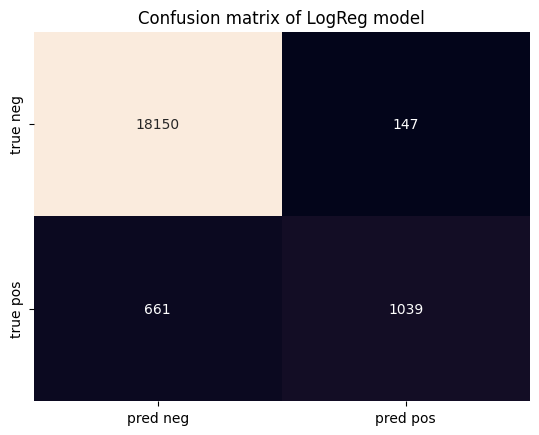

In [22]:
title="Confusion matrix of LogReg model"
validate_model(lr_model, X_test, y_test, title)

### A dummy classifier
All predcited classes are diabetes negativ

In [23]:
y_test.shape

(19997,)

In [24]:
y_dummy = np.zeros_like(y_test)
y_dummy.shape

(19997,)

Accuracy: 91.50%
Precision: 0.00%
Recall: 0.00%


c:\Users\neema\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


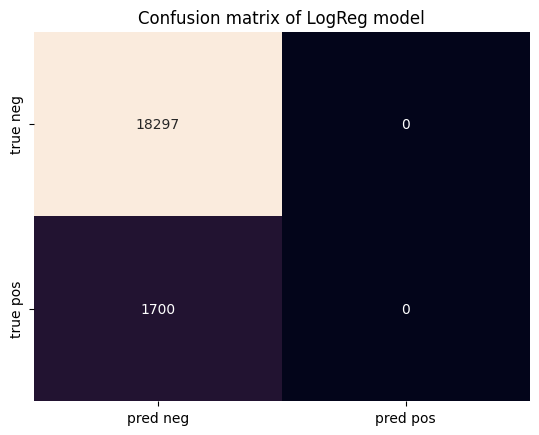

In [25]:
cm = confusion_matrix(y_test,y_dummy).astype(int)
true_labels = ['true neg', 'true pos']
pred_labels = ['pred neg', 'pred pos' ]
sns.heatmap(cm, annot=True, cbar=False, fmt='', xticklabels=pred_labels, yticklabels=true_labels).set(title=title)
acc = accuracy_score(y_test, y_dummy)
prec = precision_score(y_test, y_dummy)
recall = recall_score(y_test, y_dummy)
print(f"Accuracy: {acc *100:.2f}%")
print(f"Precision: {prec *100:.2f}%")
print(f"Recall: {recall *100:.2f}%")

## Handling the class imbalance
Although both models have quite good accuracy scores, which is of course due to the highly imbalanced dataset, they are basically useless. A model predicting medical conditions should produce as little **false negatives** as possible. This means **recall** is the important metric


### 1. Setting a class weight
+ balanced
+ overweight

In [26]:
n_samples = len(X_train)
n_classes = 2
bincount = np.bincount(y_train)

# this is the same as the 'balanced' literal
def class_weights(bias=1):
    class_weights = {0: 1/bias * n_samples/(n_classes*bincount[0]),
                    1: bias* n_samples/(n_classes*bincount[1])}
    return class_weights

lr2_model = LR(class_weight=class_weights(), random_state=11)
lr2_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.5464576074332171, 1: 5.88125},
                   random_state=11)

Accuracy: 88.39%
Precision: 41.30%
Recall: 86.76%


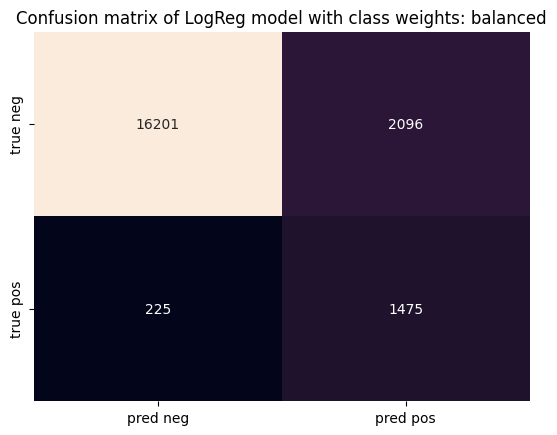

In [27]:
title="Confusion matrix of LogReg model with class weights: balanced"
validate_model(lr2_model, X_test, y_test, title)

In [28]:
# Overweight y=1

lr3_model = LR(class_weight=class_weights(2), random_state=11)
lr3_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.27322880371660857, 1: 11.7625},
                   random_state=11)

Accuracy: 76.20%
Precision: 25.90%
Recall: 96.71%


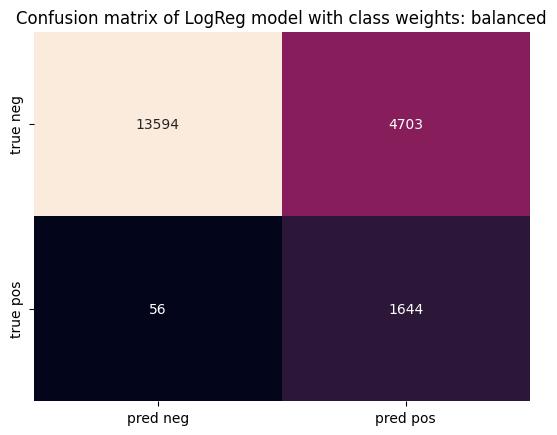

In [29]:
validate_model(lr3_model, X_test, y_test, title)

### SMOTE

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
oversampling = SMOTE()
X_train_smote, y_train_smote = oversampling.fit_resample(X_train, y_train)
np.bincount(y_train), np.bincount(y_train_smote)

(array([73185,  6800], dtype=int64), array([73185, 73185], dtype=int64))

In [32]:
lr4_model = LR(random_state=11)
lr4_model.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=11)

Accuracy: 88.49%
Precision: 41.51%
Recall: 86.41%


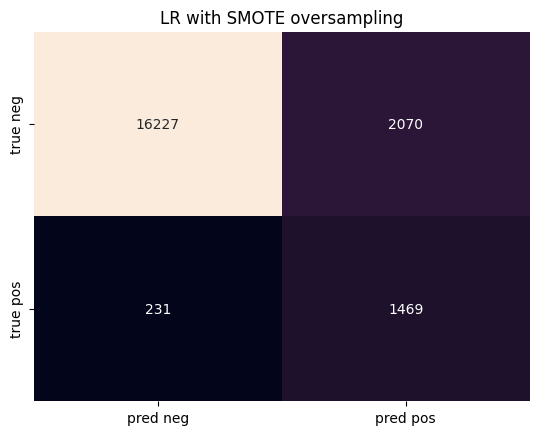

In [33]:
validate_model(lr4_model, X_test, y_test, title="LR with SMOTE oversampling")

In [34]:
# using SMOTE with overweight
lr5_model = LR(class_weight=class_weights(2), random_state=11)
lr5_model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight={0: 0.27322880371660857, 1: 11.7625},
                   random_state=11)

Accuracy: 53.62%
Precision: 15.47%
Recall: 99.82%


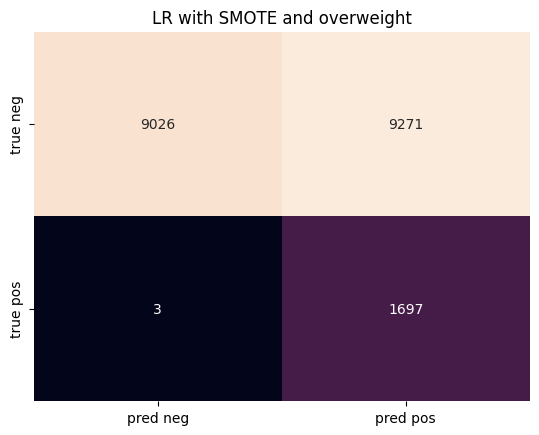

In [35]:
validate_model(lr5_model, X_test, y_test, title="LR with SMOTE and overweight")

In [36]:
# using SMOTE with radnom undersampling of majority
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

size= 36000

over = SMOTE(sampling_strategy={1: size})
under = RandomUnderSampler(sampling_strategy={0:size})
steps = [('o', over), ('u', under)]

pipe = Pipeline(steps=steps) 

In [37]:
X_train_smote_2, y_train_smote_2 = pipe.fit_resample(X_train, y_train)
np.bincount(y_train), np.bincount(y_train_smote_2)

(array([73185,  6800], dtype=int64), array([36000, 36000], dtype=int64))

Accuracy: 88.40%
Precision: 41.31%
Recall: 86.71%


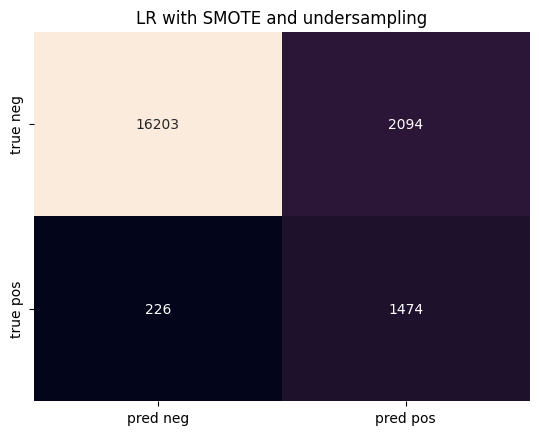

In [38]:
lr6_model = LR(random_state=11)
lr6_model.fit(X_train_smote_2, y_train_smote_2)
validate_model(lr6_model, X_test, y_test, title="LR with SMOTE and undersampling")

## Some different models

+ Decision tree
+ Random Forest
+ SVC

The **Smote with undersampling** data is used for training

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### Decision Tree

In [40]:
dtree = DecisionTreeClassifier(random_state=11)

parameter = {'splitter': ['random', 'best'],
             'max_features': [None, 2, 3]}
grid_tree = GridSearchCV(dtree, parameter)

grid_tree.fit(X_train_smote_2, y_train_smote_2)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=11),
             param_grid={'max_features': [None, 2, 3],
                         'splitter': ['random', 'best']})

Accuracy: 93.03%
Precision: 56.67%
Recall: 76.71%


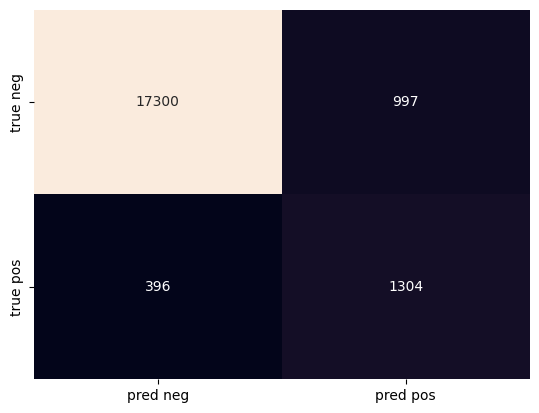

In [41]:
validate_model(grid_tree, X_test, y_test)

In [42]:
grid_tree.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
forest = RandomForestClassifier(random_state=11, n_jobs=-1)

parameter = {'n_estimators': [10, 50, 100, 200],
             'max_features': [None, 2, 3]}
grid_forest = GridSearchCV(forest, parameter)

grid_forest.fit(X_train_smote_2, y_train_smote_2)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=11),
             param_grid={'max_features': [None, 2, 3],
                         'n_estimators': [10, 50, 100, 200]})

Accuracy: 94.38%
Precision: 63.78%
Recall: 78.53%


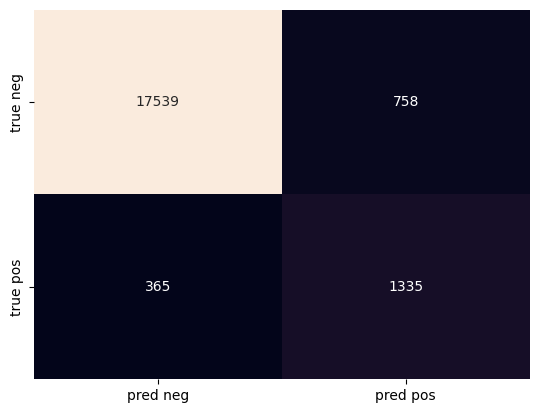

In [45]:
validate_model(grid_forest, X_test, y_test)

### SVC

In [46]:
from sklearn.svm import SVC

In [47]:
svc = SVC(random_state=11)

svc.fit(X_train_smote_2, y_train_smote_2)

SVC(random_state=11)

Accuracy: 88.60%
Precision: 42.02%
Recall: 89.82%


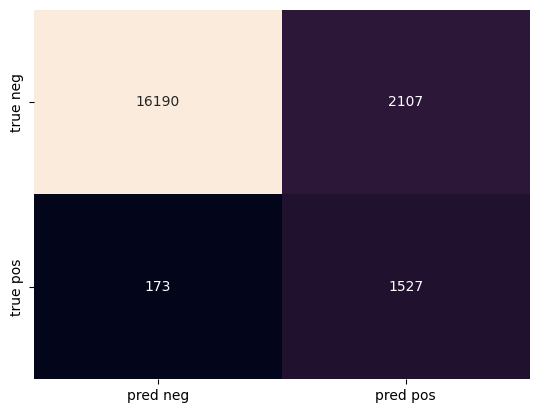

In [48]:
validate_model(svc, X_test, y_test)

## Conclusion

Given the emphasis on avoiding false negatives the Logistic Regression with SMOTE and overweighting is the model best suited for the task with a **Recal Score: 99,82%**
The SVC shows a good **Recall score of 89,82%** out of the box which surely could get improved further using class weight and/or different kernels but without any benefits over the LogReg, there is no reason to choose this compute heavy model